In [1]:
# Python
import itertools
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt 
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import funciones

In [2]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
for i in range(len(dataframes)):
  dataframes[i] = dataframes[i].reindex(pd.date_range(start=dataframes[i].index.min(), end=dataframes[i].index.max(), freq='B'))
  dataframes[i] = dataframes[i].fillna(0)
    
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

In [3]:
# TRAIN TEST
n_test = 30
train_copa = dataframes[0].iloc[:-n_test]
test_copa = dataframes[0].iloc[-n_test:]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:-n_test]
test_recursos = dataframes[1].iloc[-n_test:]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:-n_test]
test_regalias = dataframes[2].iloc[-n_test:]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((1730,)), test((30,))
Recursos: train((2187,)), test((30,))
Regalias: train((2176,)), test((30,))


In [4]:
results_train_test = []
predictions_test = []
from prophet.make_holidays import make_holidays_df
best_params = pd.read_csv("prophet_best_params.csv")
best_fourier = pd.read_csv("best_fourier_orders.csv")

for i, df_train in enumerate(dataframes_train):
    df_train = df_train.to_frame()
    df_train.reset_index(inplace=True)
    df_train.columns = ["ds", "y"]
    df_test = dataframes_test[i]
    params = eval(best_params.iloc[i]["best_params"])
    year_list = dataframes[i].index.year.unique()
    holidays = make_holidays_df(year_list=year_list, country='AR')
    model = Prophet(**params,holidays=holidays)
    
    fourier_yearly = eval(best_fourier.iloc[i]["Fourier_yearly"])["fourier_order"]  
    fourier_monthly = eval(best_fourier.iloc[i]["Fourier_monthly"])["fourier_order"]
    model.add_seasonality(name='monthly', period=30.5, fourier_order=fourier_monthly)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=fourier_yearly)

    model.fit(df_train)
    fechas = pd.date_range(start=df_test.index.min(), end=df_test.index.max(), freq='B')
    future = model.make_future_dataframe(periods=len(fechas), freq='B')
    pred_test = model.predict(future)
    pred_test.index = pred_test["ds"]
    pred_test = pred_test["yhat"]
    pred_test = pred_test[-len(df_test):]
    
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    mse_test = mean_squared_error(df_test, pred_test)
    mae_test = mean_absolute_error(df_test, pred_test)
    rmse = np.sqrt(mean_squared_error(df_test, pred_test))
    results_train_test.append({
        "model": model,
        "name": titulos[i],
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_test": mape_test,
        "mse_test":mse_test,
        "mape_mean": mape_mean,
        "mae_test": mae_test,
        "rmse": rmse
    })


13:00:15 - cmdstanpy - INFO - Chain [1] start processing
13:00:15 - cmdstanpy - INFO - Chain [1] done processing
13:00:16 - cmdstanpy - INFO - Chain [1] start processing
13:00:16 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing
13:00:17 - cmdstanpy - INFO - Chain [1] done processing


,model,name,len_train,len_test,mape_test,mse_test,mape_mean,mae_test,rmse
0,<prophet.forecaster.Prophet object at 0x000002...,CHU_COPA_AJUST,1730,30,0.93,"2,725,720,259,371.75",1.12,"1,229,244.94","1,650,975.55"
1,<prophet.forecaster.Prophet object at 0x000002...,CHU_REC_PROPIOS_AJUST,2187,30,2.00,"1,054,314,744,205.18",1.59,"794,338.12","1,026,798.30"
2,<prophet.forecaster.Prophet object at 0x000002...,CHU_REGALIAS_AJUST,2176,30,"2,422,839,158,732,645,466,112.00","41,214,444,351,485.29","6,257,919,916,697,384,386,560.00","2,479,787.70","6,419,847.69"


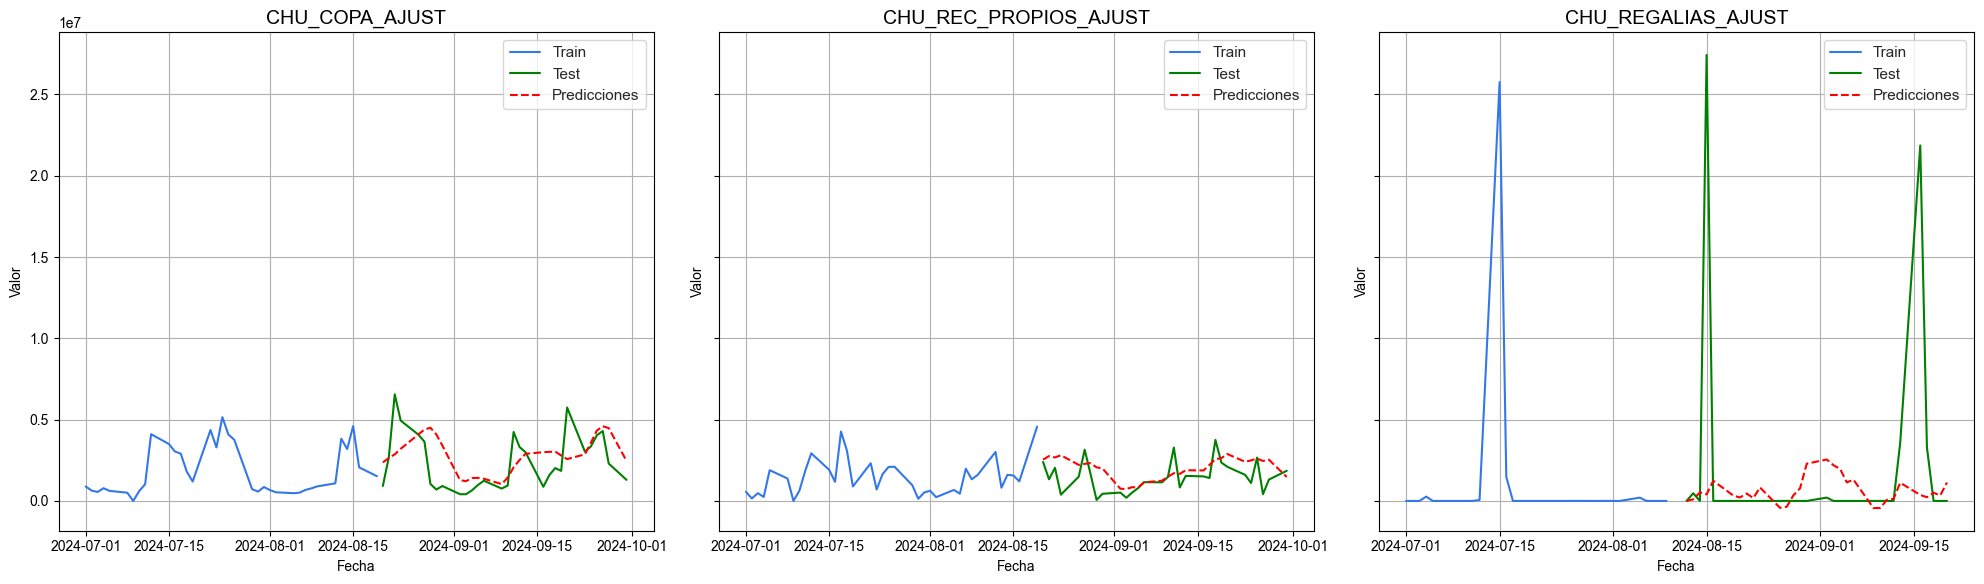

None

In [5]:
pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-07-01'
))